In this notebook, I analyze the gauges within the basins I’m working with. For basins with multiple gauges, I take the mean, and for basins without any gauges, I assign the closest one.

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
from pathlib import Path
import matplotlib.dates as mdates
import calendar
import numpy as np
import matplotlib.cm as cm
from adjustText import adjust_text

In [2]:
# --------------------------- Paths ---------------------------
DATA_DIR = Path("./filtered_data/time_series")
PLOTS_DIR = Path("./UY_basins_S+P+T")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
UYPRECIP_DIR=Path("./precip_uy")
SHAPE_DIR=Path('./watersheds/shapefile')
NAME_ATTRIBUTES=Path('./filtered_data/attributes/attributes.csv')
OUT_TS_DIR = Path("./data/new_precip_UY_basins_timeseries")
OUT_TS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
with open("./all_uruguay_basins.txt", "r") as f:
    files = [f"../data/time_series/{line.strip()}.nc" for line in f]

# Map with Uruguay basins

In [4]:
# List all .zip shapefiles except the one containing "mercedes"
zip_files = [f for f in SHAPE_DIR.glob("*.zip") if "mercedes" not in f.stem.lower()]

# Read and combine them into a single GeoDataFrame (optional)
gdfs = []
for zip_file in zip_files:
    gdf = gpd.read_file(f"zip://{zip_file}")
    gdf["source"] = zip_file.stem  # keep track of which shapefile it came from
    gdfs.append(gdf)

combined = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs)

# Reproject to WGS84 for Folium (required)
combined = combined.to_crs(epsg=4326)

# Explore interactively (with a background map)
combined.explore(
    column="source",          # color by shapefile name
    cmap="tab20",             # nice color palette
    tooltip=["source"],       # show the source name when hovering
    style_kwds={"fillOpacity": 0.4, "weight": 1},
    tiles="OpenStreetMap"     # or "CartoDB positron", "Stamen Terrain", etc.
)


In [5]:
gauges_coords=pd.read_excel(f'{UYPRECIP_DIR}/COORDENADAS.xlsx')
gauges_coords.head()

,lat,lon,Estacion,Departamento,Tipo,Adm
0,-33.72,-53.55,18 de Julio,Rocha,Convencional,INUMET
1,-34.36,-54.06,19 de Abril,Rocha,Convencional,INUMET
2,-34.41,-56.39,25 de Agosto,Florida,Convencional,INUMET
3,-31.87,-54.16,Acegua,Cerro Largo,Convencional,INUMET
4,-32.40,-56.18,Achar,Tacuarembó,Convencional,INUMET


In [6]:
# --- Load gauges DataFrame ---
# (assuming gauges_coors is already a pandas DataFrame)
gauges_gdf = gpd.GeoDataFrame(
    gauges_coords,
    geometry=gpd.points_from_xy(gauges_coords.lon, gauges_coords.lat),
    crs="EPSG:4326"
)

# Map with UY basins + precipitation gauges

In [7]:
# --- Interactive map ---
m = combined.explore(
    column="source",
    cmap="tab20",
    style_kwds={"fillOpacity": 0.4, "weight": 1},
    tiles="CartoDB positron",
    name="Basins"
)

gauges_gdf.explore(
    m=m,
    color="red",
    marker_kwds={"radius": 5},
    tooltip=["Estacion", "Departamento", "Tipo", "Adm"],
    name="Gauges"
)

m

In [8]:
# Make sure both are in the same crs
gauges_gdf = gauges_gdf.to_crs(combined.crs)

# #Clipping stations
# gauges_in_basins = gpd.clip(gauges_gdf, combined)

# Spatial join: points get polygon attributes
gauges_in_basins = gpd.sjoin(
    gauges_gdf,
    combined[["source", "geometry"]],
    how="inner",
    predicate="within"
)

gauges_in_basins = gauges_in_basins.rename(
    columns={"source": "basin_source"}
)

gauges_in_basins.head()

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source
16,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno
22,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos
47,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar
50,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho
60,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo


In [9]:
print(f"Total gauges before clipping: {len(gauges_gdf)}")
print(f"Total gauges inside basins: {len(gauges_in_basins)}")

Total gauges before clipping: 150
Total gauges inside basins: 19


In [10]:
# Basins that already have at least one gauge
basins_with_gauge = gauges_in_basins['basin_source'].unique()

# Basins missing a gauge
basins_missing = combined.loc[~combined['source'].isin(basins_with_gauge)].copy()
print(f"Basins missing gauges: {len(basins_missing)}")

Basins missing gauges: 5


In [11]:
# Basins that already have at least one gauge
basins_with_gauge = gauges_in_basins['basin_source'].unique()

# Basins missing a gauge
basins_missing = combined.loc[~combined['source'].isin(basins_with_gauge)].copy()
print(f"Basins missing gauges: {len(basins_missing)}")

if len(basins_missing) > 0:
    # use sjoin_nearest: left=basins_missing, right=gauges_gdf
    nearest = gpd.sjoin_nearest(
        basins_missing[['source', 'geometry']],
        gauges_gdf,
        how='left',
        distance_col='dist'
    ).reset_index()

    # Build assigned rows by looking up the matched gauge by index_right
    assigned_rows = []
    for _, row in nearest.iterrows():
        gauge_idx = int(row['index_right'])
        gauge = gauges_gdf.loc[gauge_idx].copy()
        gauge['basin_source'] = row['source']          # assign this basin to that gauge
        gauge['dist_to_basin_m'] = row['dist']         # distance (units of CRS)
        gauge['assigned_nearest'] = True
        assigned_rows.append(gauge)

    assigned_gdf = gpd.GeoDataFrame(assigned_rows).reset_index(drop=True)
    assigned_gdf = assigned_gdf.set_crs(gauges_gdf.crs, allow_override=True)

    # Keep column set consistent with gauges_in_basins (add any missing cols if necessary)
    for c in gauges_in_basins.columns:
        if c not in assigned_gdf.columns:
            assigned_gdf[c] = pd.NA

    # Append and reset index
    gauges_in_basins = pd.concat([gauges_in_basins, assigned_gdf[gauges_in_basins.columns]], ignore_index=True, sort=False)

print(f"Total gauge assignments (original + nearest): {len(gauges_in_basins)}")

Basins missing gauges: 5


Total gauge assignments (original + nearest): 24


/home/azureuser/miniconda3/envs/neuralhydrology/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [12]:
gauges_in_basins.head()

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo


In [13]:
# --- Group gauges by basin ---
basin_groups = gauges_in_basins.groupby("basin_source")

In [14]:
m = combined.explore(
    column="source",
    cmap="tab20",
    style_kwds={"fillOpacity": 0.4, "weight": 1},
    tiles="CartoDB positron",
    name="Basins"
)

gauges_in_basins.explore(
    m=m,
    color="red",
    marker_kwds={"radius": 5},
    tooltip=["Estacion", "Departamento", "Tipo", "Adm"],
    name="Gauges (inside basins)"
)

m

In [15]:
# # --------------------------- Clip gauges to basins ---------------------------
# gauges_in_basins = gpd.sjoin(
#     gauges_gdf,
#     combined[['source', 'geometry']],
#     how='inner',
#     predicate='within'
# ).rename(columns={'source': 'basin_source'}).reset_index(drop=True)

# print(f"Total gauges inside basins: {len(gauges_in_basins)}")

In [16]:
gauges_in_basins

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo
5,-33.52,-56.41,Goñi,Florida,Convencional,INUMET,POINT (-56.41 -33.52),0,durazno
6,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),2,paso_de_la_compania
7,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),10,paso_del_borracho
8,-31.60,-54.97,Moirones,Rivera,Convencional,INUMET,POINT (-54.97 -31.6),11,picada_de_coelho
9,-33.50,-57.79,Palmitas,Soriano,Convencional,INUMET,POINT (-57.79 -33.5),5,bequelo


In [17]:
#Como no tengo el csv con precipitación de la estación Sarandi del Yi, asigno Cerro Chato que es la otra mas cercana
gauges_in_basins.at[21, 'Estacion'] = 'Cerro Chato'
gauges_in_basins

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo
5,-33.52,-56.41,Goñi,Florida,Convencional,INUMET,POINT (-56.41 -33.52),0,durazno
6,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),2,paso_de_la_compania
7,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),10,paso_del_borracho
8,-31.60,-54.97,Moirones,Rivera,Convencional,INUMET,POINT (-54.97 -31.6),11,picada_de_coelho
9,-33.50,-57.79,Palmitas,Soriano,Convencional,INUMET,POINT (-57.79 -33.5),5,bequelo


In [18]:
mapping = {
    'paso_de_la_compania': 'CAMELS_UY_1',
    'paso_de_las_piedras': 'CAMELS_UY_2',
    'paso_manuel_diaz': 'CAMELS_UY_3',
    'tacuarembo': 'CAMELS_UY_4',
    'paso_baltasar': 'CAMELS_UY_5',
    'paso_del_borracho': 'CAMELS_UY_6',
    'picada_de_coelho': 'CAMELS_UY_7',
    'paso_de_las_toscas': 'CAMELS_UY_8',
    'paso_aguiar': 'CAMELS_UY_9',
    'paso_mazangano': 'CAMELS_UY_10',
    'fraile_muerto': 'CAMELS_UY_11',
    'sarandi_del_yi': 'CAMELS_UY_12',
    'durazno': 'CAMELS_UY_13',
    'paso_de_los_mellizos': 'CAMELS_UY_14',
    'paso_de_las_piedras_rn': 'CAMELS_UY_15',
    'bequelo': 'CAMELS_UY_16'
}

gauges_in_basins['nc_file_name'] = gauges_in_basins['basin_source'].map(mapping)

In [19]:
gauges_in_basins

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source,nc_file_name
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno,CAMELS_UY_13
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos,CAMELS_UY_14
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar,CAMELS_UY_9
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho,CAMELS_UY_6
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo,CAMELS_UY_4
5,-33.52,-56.41,Goñi,Florida,Convencional,INUMET,POINT (-56.41 -33.52),0,durazno,CAMELS_UY_13
6,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),2,paso_de_la_compania,CAMELS_UY_1
7,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),10,paso_del_borracho,CAMELS_UY_6
8,-31.60,-54.97,Moirones,Rivera,Convencional,INUMET,POINT (-54.97 -31.6),11,picada_de_coelho,CAMELS_UY_7
9,-33.50,-57.79,Palmitas,Soriano,Convencional,INUMET,POINT (-57.79 -33.5),5,bequelo,CAMELS_UY_16


In [20]:
estacion_mapping = {
    "Capilla del Sauce": "Capilla del Sauce 1981-2024",
    "Cañada Grande": "Canada Grande 1981-2024",
    "Cuchilla Caragauta N": "Cuchilla Caraguata Norte 1981-2024",
    "Cuchilla del Ombu": "Cuchilla del Ombu 1982-2024",
    "El Molino": "El Molino 1981-2024",
    "Goñi": "Goni 1981-2024",
    "Minas de Corrales": "Minas de Corrales 1981-2024",  
    "Moirones": "Moirones 1981-2024",
    "Palmitas": "Palmitas 1981-2024",
    "Paso de la Cruz_RN": "Paso de la Cruz_rn 1981-2024",
    "Polanco del Yi": "Polanco del Yi 1981-2024",
    "Rossell y Rius": "Rossell y Rius 1981-2024",
    # "Sarandi del Yi": "", #CSV with gauge precip missing
    # "Sarandi Grande": "", #CSV with gauge precip missing
    "Rivera": "Rivera 1981-2024",
    "Cerro de las Cuentas": "Cerro de las Cuentas 1981-2024",
    "Cerro Chato": "Cerro Chato 1981-2024",
    "Tranqueras": "Tranqueras_1982_2024",  
    "Vichadero": "Vichadero_1981_2024",   
}

gauges_in_basins['estacion_file_name'] = gauges_in_basins['Estacion'].map(estacion_mapping)

In [21]:
gauges_in_basins

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source,nc_file_name,estacion_file_name
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno,CAMELS_UY_13,Capilla del Sauce 1981-2024
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos,CAMELS_UY_14,Canada Grande 1981-2024
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar,CAMELS_UY_9,Cuchilla Caraguata Norte 1981-2024
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho,CAMELS_UY_6,Cuchilla del Ombu 1982-2024
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo,CAMELS_UY_4,El Molino 1981-2024
5,-33.52,-56.41,Goñi,Florida,Convencional,INUMET,POINT (-56.41 -33.52),0,durazno,CAMELS_UY_13,Goni 1981-2024
6,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),2,paso_de_la_compania,CAMELS_UY_1,Minas de Corrales 1981-2024
7,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),10,paso_del_borracho,CAMELS_UY_6,Minas de Corrales 1981-2024
8,-31.60,-54.97,Moirones,Rivera,Convencional,INUMET,POINT (-54.97 -31.6),11,picada_de_coelho,CAMELS_UY_7,Moirones 1981-2024
9,-33.50,-57.79,Palmitas,Soriano,Convencional,INUMET,POINT (-57.79 -33.5),5,bequelo,CAMELS_UY_16,Palmitas 1981-2024


# Pruebas

In [22]:
# Precipitation from gauge
palmitas=pd.read_excel(f'{UYPRECIP_DIR}/Palmitas 1981-2024.xlsx')
palmitas['Fecha'] = pd.to_datetime(palmitas['Fecha'])
palmitas['[mm]'] = pd.to_numeric(palmitas['[mm]'], errors='coerce')
palmitas

,Estación,Cod. Pluvio,Fecha,[mm],Comentario
0,Palmitas,2289A,1981-01-01,0.0,NaN
1,Palmitas,2289A,1981-01-02,34.0,NaN
2,Palmitas,2289A,1981-01-03,0.0,NaN
3,Palmitas,2289A,1981-01-04,0.0,NaN
4,Palmitas,2289A,1981-01-05,21.0,NaN
...,...,...,...,...,...
16054,Palmitas,2289A,2024-12-15,2.0,NaN
16055,Palmitas,2289A,2024-12-16,0.0,NaN
16056,Palmitas,2289A,2024-12-17,0.0,NaN
16057,Palmitas,2289A,2024-12-18,0.0,NaN


In [23]:
bequelo=xr.open_dataset('/inputs/data_updated_2/time_series/CAMELS_UY_16.nc')
bequelo

<xarray.Dataset> Size: 2MB
Dimensions:                                        (date: 14610)
Coordinates:
  * date                                           (date) datetime64[ns] 117kB ...
Data variables: (12/40)
    snow_depth_water_equivalent_mean               (date) float32 58kB ...
    surface_net_solar_radiation_mean               (date) float32 58kB ...
    surface_net_thermal_radiation_mean             (date) float32 58kB ...
    surface_pressure_mean                          (date) float32 58kB ...
    temperature_2m_mean                            (date) float32 58kB ...
    dewpoint_temperature_2m_mean                   (date) float32 58kB ...
    ...                                             ...
    volumetric_soil_water_layer_3_max              (date) float32 58kB ...
    volumetric_soil_water_layer_4_max              (date) float32 58kB ...
    total_precipitation_sum                        (date) float32 58kB ...
    potential_evaporation_sum_ERA5_LAND            (date) float32 58kB ...
    potential_evaporation_sum_FAO_PENMAN_MONTEITH  (date) float32 58kB ...
    streamflow                                     (date) float32 58kB ...
Attributes:
    Units:     potential_evaporation_sum_ERA5_LAND: Potential Evaporation [mm...
    Timezone:  America/Montevideo
    Sources:   All forcing and state variables are derived from ERA5-Land hou...

In [24]:
bequelo_filtered=xr.open_dataset('./filtered_data/time_series/CAMELS_UY_16.nc')
bequelo_filtered

<xarray.Dataset> Size: 362kB
Dimensions:      (date: 11322)
Coordinates:
  * date         (date) datetime64[ns] 91kB 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    tmin_C       (date) float32 45kB ...
    tmax_C       (date) float32 45kB ...
    srad_W_m2    (date) float32 45kB ...
    prcp_mm_day  (date) float32 45kB ...
    QObs_mm_d    (date) float64 91kB ...

In [25]:
# --- Load gauge data ---
palmitas = pd.read_excel('./precip_uy/Palmitas 1981-2024.xlsx')  # adjust path
# Identify the precipitation column (contains '[mm]')
precip_col = [c for c in palmitas.columns if '[mm]' in c][0]

# Convert date and precipitation to proper types
palmitas['Fecha'] = pd.to_datetime(palmitas['Fecha'])
palmitas[precip_col] = pd.to_numeric(palmitas[precip_col], errors='coerce')

# Keep only date + precipitation
df_gauge = palmitas[['Fecha', precip_col]].rename(columns={precip_col: 'precip_gauge'})

# --- Load xarray precipitation data ---
bequelo = xr.open_dataset('/inputs/data_updated_2/time_series/CAMELS_UY_16.nc')

# Convert xarray variable to DataFrame, keep date as index
df_xr = bequelo[['total_precipitation_sum']].to_dataframe().reset_index()
df_xr = df_xr.rename(columns={'date': 'Fecha', 'total_precipitation_sum': 'precip_model'})

# --- Align gauge data to xarray dates ---
# Merge using xarray dates as reference (left join)
df_all = pd.merge(df_xr, df_gauge, on='Fecha', how='left')  # only keeps xarray dates
df_all = df_all.sort_values('Fecha').reset_index(drop=True)

df_all.head()


,Fecha,precip_model,precip_gauge
0,1981-01-01,0.50,0.0
1,1981-01-02,13.51,34.0
2,1981-01-03,1.04,0.0
3,1981-01-04,0.00,0.0
4,1981-01-05,0.00,21.0


In [26]:
df_all['dif']=df_all['precip_gauge']-df_all['precip_model']
df_all['abs_dif'] = abs(df_all['precip_gauge'] - df_all['precip_model'])

In [27]:
df_all

,Fecha,precip_model,precip_gauge,dif,abs_dif
0,1981-01-01,0.50,0.0,-0.50,0.50
1,1981-01-02,13.51,34.0,20.49,20.49
2,1981-01-03,1.04,0.0,-1.04,1.04
3,1981-01-04,0.00,0.0,0.00,0.00
4,1981-01-05,0.00,21.0,21.00,21.00
...,...,...,...,...,...
14605,2020-12-27,0.00,0.0,0.00,0.00
14606,2020-12-28,0.15,0.0,-0.15,0.15
14607,2020-12-29,0.03,0.0,-0.03,0.03
14608,2020-12-30,3.56,3.5,-0.06,0.06


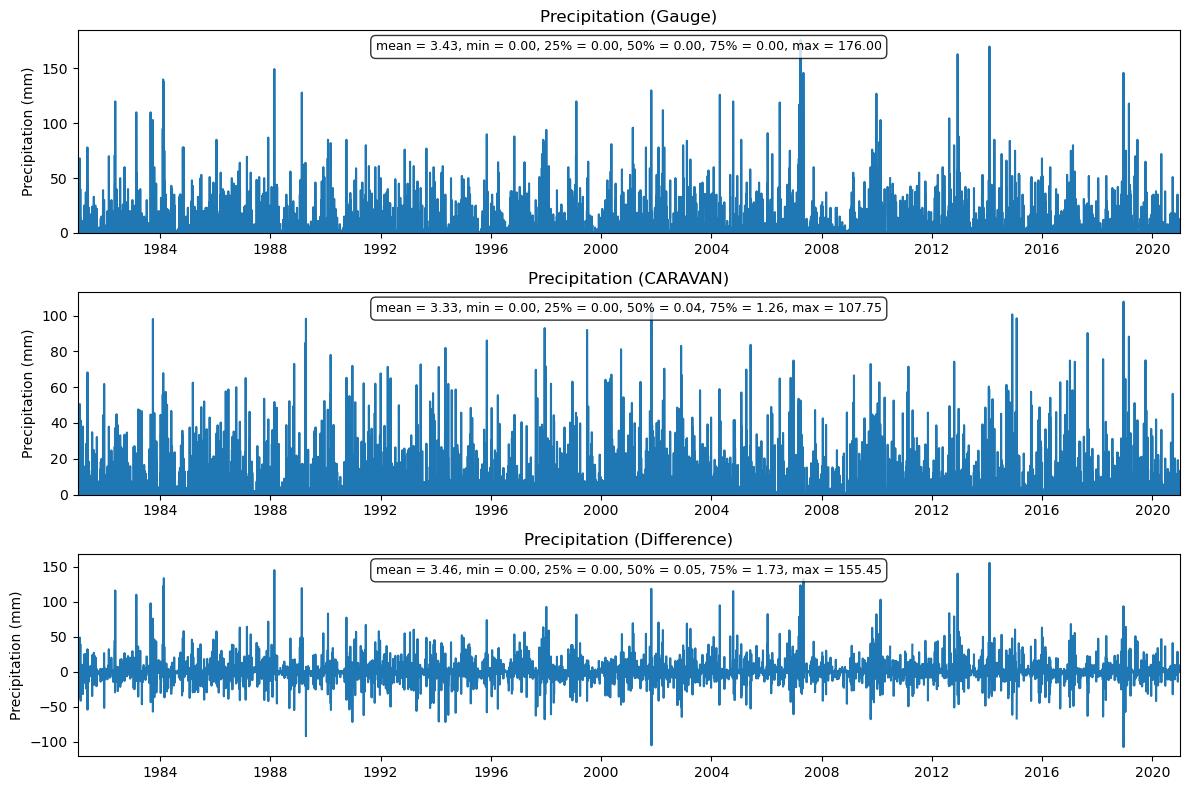

In [28]:
fix,ax=plt.subplots(3,1,figsize=(12,8))

palmitas['Fecha'] = pd.to_datetime(palmitas['Fecha'])

ax[0].plot(df_all['Fecha'],df_all['precip_gauge'])
ax[1].plot(df_all['Fecha'],df_all['precip_model'])
ax[2].plot(df_all['Fecha'],df_all['dif'])

ax[0].set_xlim(df_all['Fecha'].min(),df_all['Fecha'].max())
ax[1].set_xlim(df_all['Fecha'].min(),df_all['Fecha'].max())
ax[2].set_xlim(df_all['Fecha'].min(),df_all['Fecha'].max())

ax[0].set_ylim(0, None)
ax[1].set_ylim(0, None)

ax[0].set_ylabel('Precipitation (mm)')
ax[1].set_ylabel('Precipitation (mm)')
ax[2].set_ylabel('Precipitation (mm)')

ax[0].set_title('Precipitation (Gauge)')
ax[1].set_title('Precipitation (CARAVAN)')
ax[2].set_title('Precipitation (Difference)')

# --- Add concise summary boxes for each variable ---
variables = ['precip_gauge', 'precip_model', 'abs_dif']

for a, var in zip(ax, variables):
    stats = df_all[var].describe()
    summary_text = (
        f"mean = {stats['mean']:.2f}, min = {stats['min']:.2f}, "
        f"25% = {stats['25%']:.2f}, 50% = {stats['50%']:.2f}, "
        f"75% = {stats['75%']:.2f}, max = {stats['max']:.2f}"
    )
    a.text(
        0.5, 0.95, summary_text,
        transform=a.transAxes,
        fontsize=9,
        ha='center',
        va='top',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.4')
    )

plt.tight_layout()
plt.show()

In [29]:
df_all

,Fecha,precip_model,precip_gauge,dif,abs_dif
0,1981-01-01,0.50,0.0,-0.50,0.50
1,1981-01-02,13.51,34.0,20.49,20.49
2,1981-01-03,1.04,0.0,-1.04,1.04
3,1981-01-04,0.00,0.0,0.00,0.00
4,1981-01-05,0.00,21.0,21.00,21.00
...,...,...,...,...,...
14605,2020-12-27,0.00,0.0,0.00,0.00
14606,2020-12-28,0.15,0.0,-0.15,0.15
14607,2020-12-29,0.03,0.0,-0.03,0.03
14608,2020-12-30,3.56,3.5,-0.06,0.06


In [30]:
df_all['Fecha'] = pd.to_datetime(df_all['Fecha'])  # ensure it's datetime
df_all['year'] = df_all['Fecha'].dt.year

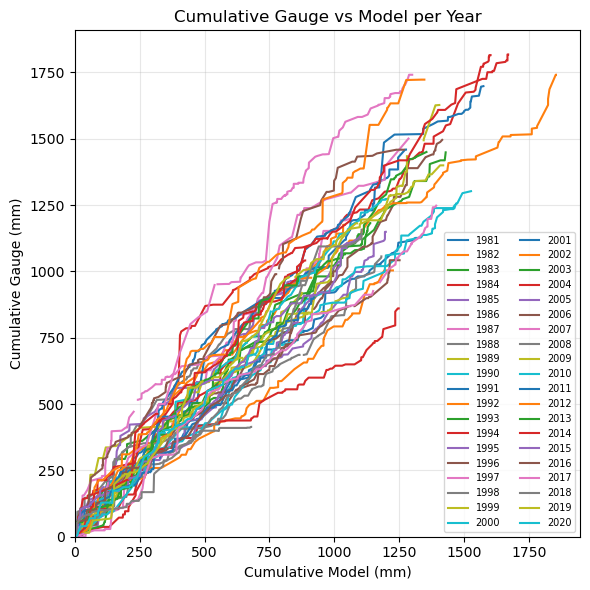

In [31]:
fig, ax = plt.subplots(figsize=(6, 6))

for year, group in df_all.groupby('year'):
    group = group.sort_values('Fecha')
    cum_model = group['precip_model'].cumsum()
    cum_gauge = group['precip_gauge'].cumsum()
    
    # Let matplotlib pick colors automatically
    ax.plot(cum_model, cum_gauge, label=str(year), lw=1.5)

ax.set_xlabel("Cumulative Model (mm)")
ax.set_ylabel("Cumulative Gauge (mm)")
ax.set_title("Cumulative Gauge vs Model per Year")
ax.grid(alpha=0.3)
ax.legend(ncol=2, fontsize=7)
ax.set_xlim(0,None)
ax.set_ylim(0,None)
plt.tight_layout()
plt.show()

In [32]:
df_all

,Fecha,precip_model,precip_gauge,dif,abs_dif,year
0,1981-01-01,0.50,0.0,-0.50,0.50,1981
1,1981-01-02,13.51,34.0,20.49,20.49,1981
2,1981-01-03,1.04,0.0,-1.04,1.04,1981
3,1981-01-04,0.00,0.0,0.00,0.00,1981
4,1981-01-05,0.00,21.0,21.00,21.00,1981
...,...,...,...,...,...,...
14605,2020-12-27,0.00,0.0,0.00,0.00,2020
14606,2020-12-28,0.15,0.0,-0.15,0.15,2020
14607,2020-12-29,0.03,0.0,-0.03,0.03,2020
14608,2020-12-30,3.56,3.5,-0.06,0.06,2020


(0.0, 52064.354999999996)

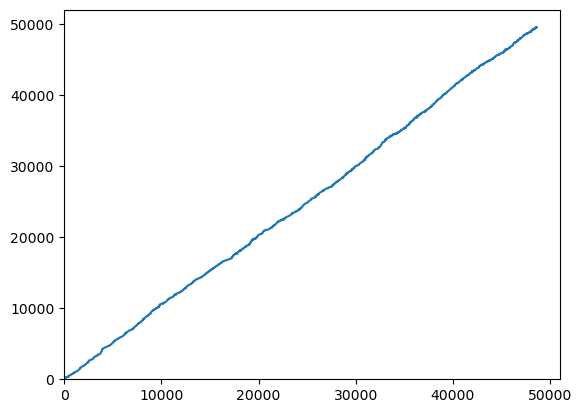

In [33]:
plt.plot(df_all['precip_model'].cumsum(),df_all['precip_gauge'].cumsum())
plt.xlim(0,None)
plt.ylim(0,None)

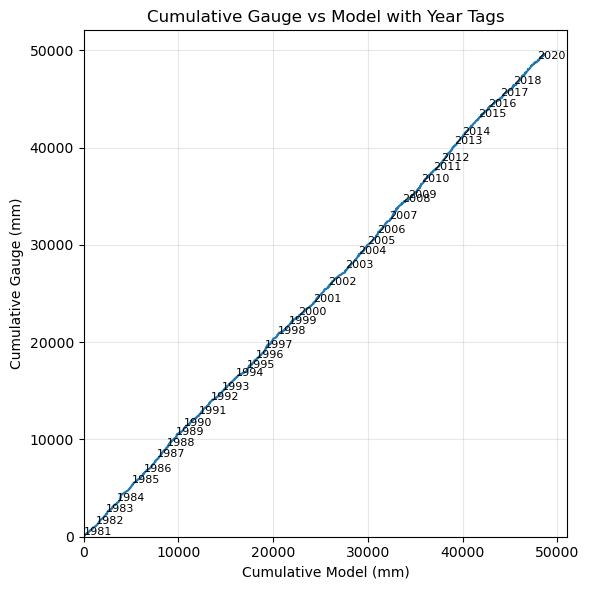

In [34]:
# Compute cumulative sums over the whole period
df_all['cum_model'] = df_all['precip_model'].cumsum()
df_all['cum_gauge'] = df_all['precip_gauge'].cumsum()

# Identify the first date of each year
first_days = df_all.loc[df_all.groupby('year')['Fecha'].idxmin()]

# Plot cumulative curve
plt.figure(figsize=(6, 6))
plt.plot(df_all['cum_model'], df_all['cum_gauge'], lw=1.5)

# Add year tags at each year's first day
for _, row in first_days.iterrows():
    plt.text(row['cum_model'], row['cum_gauge'], str(row['year']),
             fontsize=8, color='black', ha='left', va='bottom')

plt.xlabel("Cumulative Model (mm)")
plt.ylabel("Cumulative Gauge (mm)")
plt.title("Cumulative Gauge vs Model with Year Tags")
plt.grid(alpha=0.3)
plt.xlim(0, None)
plt.ylim(0, None)
plt.tight_layout()
plt.show()

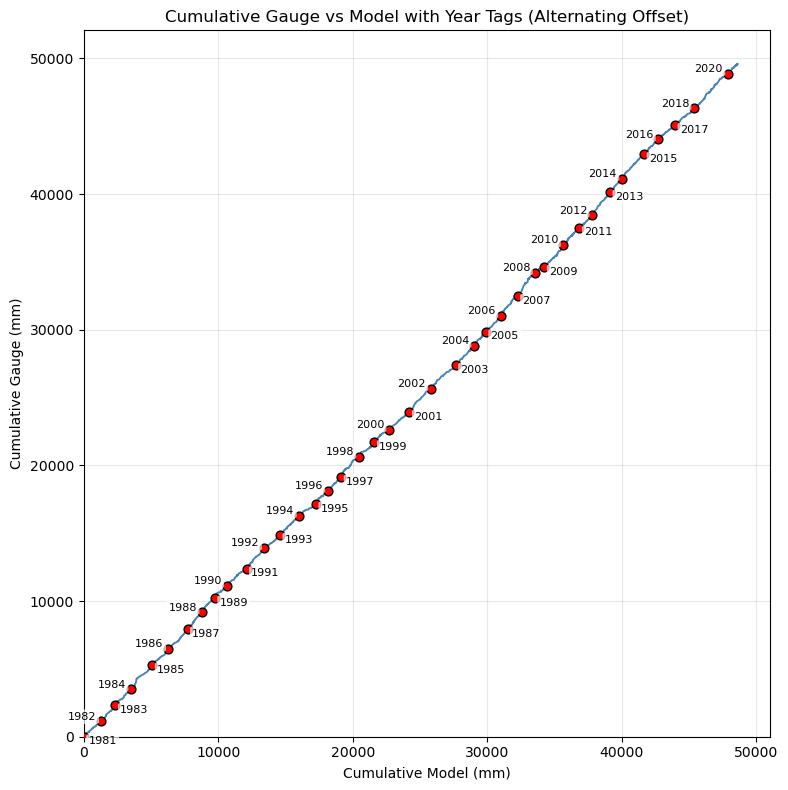

In [35]:
# Ensure Fecha is datetime
df_all['Fecha'] = pd.to_datetime(df_all['Fecha'])

# Compute cumulative sums
df_all['cum_model'] = df_all['precip_model'].cumsum()
df_all['cum_gauge'] = df_all['precip_gauge'].cumsum()

# Identify the first date of each year
first_days = df_all.loc[df_all.groupby('year')['Fecha'].idxmin()]

# Plot cumulative curve
plt.figure(figsize=(8, 8))
plt.plot(df_all['cum_model'], df_all['cum_gauge'], lw=1.3, color='steelblue')

plt.scatter(
    first_days['cum_model'], 
    first_days['cum_gauge'], 
    s=40,              # marker size
    color='red',       # highlight color
    edgecolor='black', # black border for contrast
    zorder=3,          # make sure markers are above line
    label='Year start'
)

for i, (_, row) in enumerate(first_days.iterrows()):
    offset = 350 if i % 2 == 0 else -350
    plt.text(
        row['cum_model'] + offset, 
        row['cum_gauge'] - offset, 
        str(row['year']),
        fontsize=8,
        color='black',
        ha='left' if i % 2 == 0 else 'right',
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
    )

plt.xlabel("Cumulative Model (mm)")
plt.ylabel("Cumulative Gauge (mm)")
plt.title("Cumulative Gauge vs Model with Year Tags (Alternating Offset)")
plt.grid(alpha=0.3)
plt.xlim(0, None)
plt.ylim(0, None)
plt.tight_layout()
plt.show()

In [36]:
gauges_in_basins

,lat,lon,Estacion,Departamento,Tipo,Adm,geometry,index_right,basin_source,nc_file_name,estacion_file_name
0,-33.46,-55.63,Capilla del Sauce,Florida,Convencional,INUMET,POINT (-55.63 -33.46),0,durazno,CAMELS_UY_13,Capilla del Sauce 1981-2024
1,-32.51,-57.16,Cañada Grande,Rio Negro,Convencional,INUMET,POINT (-57.16 -32.51),8,paso_de_los_mellizos,CAMELS_UY_14,Canada Grande 1981-2024
2,-32.13,-54.89,Cuchilla Caragauta N,Tacuarembó,Convencional,INUMET,POINT (-54.89 -32.13),4,paso_aguiar,CAMELS_UY_9,Cuchilla Caraguata Norte 1981-2024
3,-31.77,-55.69,Cuchilla del Ombu,Tacuarembó,Convencional,INUMET,POINT (-55.69 -31.77),10,paso_del_borracho,CAMELS_UY_6,Cuchilla del Ombu 1982-2024
4,-31.71,-56.00,El Molino,Tacuarembó,Convencional,INUMET,POINT (-56 -31.71),15,tacuarembo,CAMELS_UY_4,El Molino 1981-2024
5,-33.52,-56.41,Goñi,Florida,Convencional,INUMET,POINT (-56.41 -33.52),0,durazno,CAMELS_UY_13,Goni 1981-2024
6,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),2,paso_de_la_compania,CAMELS_UY_1,Minas de Corrales 1981-2024
7,-31.57,-55.47,Minas de Corrales,Rivera,Convencional,INUMET,POINT (-55.47 -31.57),10,paso_del_borracho,CAMELS_UY_6,Minas de Corrales 1981-2024
8,-31.60,-54.97,Moirones,Rivera,Convencional,INUMET,POINT (-54.97 -31.6),11,picada_de_coelho,CAMELS_UY_7,Moirones 1981-2024
9,-33.50,-57.79,Palmitas,Soriano,Convencional,INUMET,POINT (-57.79 -33.5),5,bequelo,CAMELS_UY_16,Palmitas 1981-2024


# Precipitation comparisson (gauges vs ERA5) (3 plots)

In [37]:
# # --- Loop over basins with gauges ---
# for basin_name, group in gauges_in_basins.groupby("basin_source"):
#     print(f"Processing basin: {basin_name}")

#     # --------------------------- Load and combine gauge data ---------------------------
#     precip_list = []
#     for _, row in group.iterrows():
#         if pd.isna(row['estacion_file_name']):
#             continue  # skip if no Excel file name provided

#         gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
#         if not gauge_file.exists():
#             print(f"  ⚠️ Missing file: {gauge_file}")
#             continue

#         gauge_df = pd.read_excel(gauge_file)
#         precip_col = [c for c in gauge_df.columns if '[mm]' in c][0]

#         gauge_df['Fecha'] = pd.to_datetime(gauge_df['Fecha'])
#         gauge_df[precip_col] = pd.to_numeric(gauge_df[precip_col], errors='coerce')
#         gauge_df = gauge_df[['Fecha', precip_col]].rename(columns={precip_col: 'precip_gauge'})
#         precip_list.append(gauge_df)

#     if not precip_list:
#         print(f"  ⚠️ No valid gauge data for {basin_name}")
#         continue

#     # --- Combine all gauges for the basin by merging on Fecha and taking mean ---
#     df_gauge = precip_list[0]
#     for i, df in enumerate(precip_list[1:], start=1):
#         df_gauge = pd.merge(
#             df_gauge,
#             df,
#             on='Fecha',
#             how='outer',
#             suffixes=('', f'_{i}')  # unique suffix for each merge to avoid conflicts
#         )
    
#     # Compute mean across all gauge columns
#     gauge_cols = [c for c in df_gauge.columns if 'precip_gauge' in c]
#     df_gauge['precip_gauge'] = df_gauge[gauge_cols].mean(axis=1)
#     df_gauge = df_gauge[['Fecha', 'precip_gauge']]

#     # --------------------------- Load xarray data ---------------------------
#     nc_file = DATA_DIR / f"{group['nc_file_name'].iloc[0]}.nc"
#     if not nc_file.exists():
#         print(f"  ⚠️ Missing NC file: {nc_file}")
#         continue

#     ds = xr.open_dataset(nc_file)
#     df_model = ds[['total_precipitation_sum']].to_dataframe().reset_index()
#     df_model = df_model.rename(columns={'date': 'Fecha', 'total_precipitation_sum': 'precip_model'})

#     # --------------------------- Merge and compare ---------------------------
#     df_all = pd.merge(df_model, df_gauge, on='Fecha', how='left').sort_values('Fecha')
#     df_all['dif'] = df_all['precip_gauge'] - df_all['precip_model']
#     df_all['abs_dif'] = df_all['dif'].abs()

#     # --------------------------- Plot ---------------------------
#     fig, ax = plt.subplots(3, 1, figsize=(12, 8))

#     ax[0].plot(df_all['Fecha'], df_all['precip_gauge'], color='tab:blue')
#     ax[1].plot(df_all['Fecha'], df_all['precip_model'], color='tab:orange')
#     ax[2].plot(df_all['Fecha'], df_all['dif'], color='tab:red')

#     for a in ax:
#         a.set_xlim(df_all['Fecha'].min(), df_all['Fecha'].max())
#         a.set_ylabel('Precipitation (mm)')

#     ax[0].set_ylim(0, None)
#     ax[1].set_ylim(0, None)
#     ax[0].set_title(f'Gauge Precipitation')
#     ax[1].set_title(f'CARAVAN Precipitation')
#     ax[2].set_title(f'Gauge - CARAVAN Difference')

#     # --- Add summary stats ---
#     variables = ['precip_gauge', 'precip_model', 'abs_dif']
#     for a, var in zip(ax, variables):
#         stats = df_all[var].describe()
#         summary_text = (
#             f"mean={stats['mean']:.2f}, min={stats['min']:.2f}, "
#             f"25%={stats['25%']:.2f}, 50%={stats['50%']:.2f}, "
#             f"75%={stats['75%']:.2f}, max={stats['max']:.2f}"
#         )
#         a.text(
#             0.5, 0.95, summary_text,`
#             transform=a.transAxes,
#             fontsize=9,
#             ha='center',
#             va='top',
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.4')
#         )

#     fig.suptitle(f"Gauge id: {group['nc_file_name'].iloc[0]}", fontsize=16, fontweight='bold', x=0.5115) #, y=0.92)
#     plt.tight_layout()
#     # plt.show()
                 
#     out_path = PLOTS_DIR / f"precip_{group['nc_file_name'].iloc[0]}.png"
#     fig.savefig(out_path, dpi=300, bbox_inches="tight")
#     plt.close(fig)

# Gauge precipitation vs CARAVAN precipitation

In [38]:
#daily values (water year)

In [39]:
# # --- Loop over basins with gauges ---
# for basin_name, group in gauges_in_basins.groupby("basin_source"):
#     print(f"Processing basin: {basin_name}")

#     # --------------------------- Load and combine gauge data ---------------------------
#     precip_list = []
#     for _, row in group.iterrows():
#         if pd.isna(row['estacion_file_name']):
#             continue  # skip if no Excel file name provided

#         gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
#         if not gauge_file.exists():
#             print(f"Missing file: {gauge_file}")
#             continue

#         gauge_df = pd.read_excel(gauge_file)
#         precip_col = [c for c in gauge_df.columns if '[mm]' in c][0]

#         gauge_df['Fecha'] = pd.to_datetime(gauge_df['Fecha'])
#         gauge_df[precip_col] = pd.to_numeric(gauge_df[precip_col], errors='coerce')
#         gauge_df = gauge_df[['Fecha', precip_col]].rename(columns={precip_col: 'precip_gauge'})
#         precip_list.append(gauge_df)

#     if not precip_list:
#         print(f"No valid gauge data for {basin_name}")
#         continue

#     # --- Combine all gauges for the basin by merging on Fecha and taking mean ---
#     df_gauge = precip_list[0]
#     for i, df in enumerate(precip_list[1:], start=1):
#         df_gauge = pd.merge(
#             df_gauge,
#             df,
#             on='Fecha',
#             how='outer',
#             suffixes=('', f'_{i}')  # unique suffix for each merge
#         )
    
#     gauge_cols = [c for c in df_gauge.columns if 'precip_gauge' in c]
#     df_gauge['precip_gauge'] = df_gauge[gauge_cols].mean(axis=1)
#     df_gauge = df_gauge[['Fecha', 'precip_gauge']]

#     # --------------------------- Load xarray data ---------------------------
#     nc_file = DATA_DIR / f"{group['nc_file_name'].iloc[0]}.nc"
#     if not nc_file.exists():
#         print(f"Missing NC file: {nc_file}")
#         continue

#     ds = xr.open_dataset(nc_file)
#     df_model = ds[['prcp_mm_day']].to_dataframe().reset_index()
#     df_model = df_model.rename(columns={'date': 'Fecha', 'prcp_mm_day': 'precip_model'})

#     # --------------------------- Merge ---------------------------
#     df_all = pd.merge(df_model, df_gauge, on='Fecha', how='left').sort_values('Fecha')

#     # --------------------------- Compute water year ---------------------------
#     df_all['water_year'] = df_all['Fecha'].dt.year
#     df_all.loc[df_all['Fecha'].dt.month >= 10, 'water_year'] += 1  # water year ends next calendar year

#     # Skip first and last incomplete water years
#     min_wy = df_all['water_year'].min() + 1
#     max_wy = df_all['water_year'].max() - 1
#     df_all = df_all[(df_all['water_year'] >= min_wy) & (df_all['water_year'] <= max_wy)]

#     # --------------------------- Cumulative plot per water year ---------------------------
#     fig, ax = plt.subplots(figsize=(8, 8))
#     texts = []

#     for wy, group_wy in df_all.groupby('water_year'):
#         group_wy = group_wy.sort_values('Fecha')
#         cum_model = group_wy['precip_model'].cumsum()
#         cum_gauge = group_wy['precip_gauge'].cumsum()

#         # Plot with transparency (no marker)
#         ax.plot(cum_model, cum_gauge, lw=1, alpha=0.7)

#         # Add a marker at the last point only
#         ax.plot(
#             cum_model.iloc[-1], cum_gauge.iloc[-1],
#             marker='o', markersize=4, color=ax.lines[-1].get_color()
#         )
        
#         # Label the water year at the end of each curve
#         texts.append(
#             ax.text(
#                 cum_model.iloc[-1], cum_gauge.iloc[-1],
#                 str(wy),
#                 fontsize=8, ha='left', va='bottom', alpha=0.9
#             )
#         )

#     # Adjust overlapping labels
#     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))
    
#     # --------------------------- 1:1 line ---------------------------
#     max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
#     ax.plot([0, max_val], [0, max_val], '--', color='black', lw=0.8, alpha=0.6, label='1:1 line')

#     # --------------------------- Formatting ---------------------------
#     ax.set_xlabel("Cumulative Precipitation: CARAVAN (mm)")
#     ax.set_ylabel("Cumulative Precipitation: Gauge (mm)")
#     ax.set_title(f"Cumulative Precipitation: Gauge vs Model per Water Year\nBasin: {group['nc_file_name'].iloc[0]}")
#     ax.grid(alpha=0.3)
#     ax.set_xlim(0, None)
#     ax.set_ylim(0, None)
#     ax.legend()
#     plt.tight_layout()

#     out_path = PLOTS_DIR / f"cum_precip_water_year_{group['nc_file_name'].iloc[0]}.png"
#     fig.savefig(out_path, dpi=300, bbox_inches="tight")
#     plt.close(fig)

In [40]:
# --- Loop over basins with gauges ---
for basin_name, group in gauges_in_basins.groupby("basin_source"):
    print(f"Processing basin: {basin_name}")

    # --------------------------- Load and combine gauge data ---------------------------
    precip_list = []
    for _, row in group.iterrows():
        if pd.isna(row['estacion_file_name']):
            continue  # skip if no Excel file name provided

        gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
        if not gauge_file.exists():
            print(f"Missing file: {gauge_file}")
            continue

        gauge_df = pd.read_excel(gauge_file)
        precip_col = [c for c in gauge_df.columns if '[mm]' in c][0]

        gauge_df['Fecha'] = pd.to_datetime(gauge_df['Fecha'])
        gauge_df[precip_col] = pd.to_numeric(gauge_df[precip_col], errors='coerce')
        gauge_df = gauge_df[['Fecha', precip_col]].rename(columns={precip_col: 'precip_gauge'})
        precip_list.append(gauge_df)

    if not precip_list:
        print(f"No valid gauge data for {basin_name}")
        continue

    # --- Combine all gauges for the basin by merging on Fecha and taking mean ---
    df_gauge = precip_list[0]
    for i, df in enumerate(precip_list[1:], start=1):
        df_gauge = pd.merge(
            df_gauge,
            df,
            on='Fecha',
            how='outer',
            suffixes=('', f'_{i}')  # unique suffix for each merge
        )
    
    gauge_cols = [c for c in df_gauge.columns if 'precip_gauge' in c]
    df_gauge['precip_gauge'] = df_gauge[gauge_cols].mean(axis=1)
    df_gauge = df_gauge[['Fecha', 'precip_gauge']]

    # --------------------------- Load xarray data ---------------------------
    nc_file = DATA_DIR / f"{group['nc_file_name'].iloc[0]}.nc"
    if not nc_file.exists():
        print(f"Missing NC file: {nc_file}")
        continue

    ds = xr.open_dataset(nc_file)
    df_model = ds[['prcp_mm_day']].to_dataframe().reset_index()
    df_model = df_model.rename(columns={'date': 'Fecha', 'prcp_mm_day': 'precip_model'})

    # --------------------------- Merge ---------------------------
    df_all = pd.merge(df_model, df_gauge, on='Fecha', how='left').sort_values('Fecha')

    # --------------------------- Compute water year ---------------------------
    df_all['water_year'] = df_all['Fecha'].dt.year
    df_all.loc[df_all['Fecha'].dt.month >= 10, 'water_year'] += 1  # water year ends next calendar year

    # Skip first and last incomplete water years
    min_wy = df_all['water_year'].min() + 1
    max_wy = df_all['water_year'].max() - 1
    df_all = df_all[(df_all['water_year'] >= min_wy) & (df_all['water_year'] <= max_wy)]

    # --------------------------- Cumulative plot per water year ---------------------------
    fig, ax = plt.subplots(figsize=(8, 8))
    texts = []

    # Compute annual (total) sums per water year for label positioning
    wy_totals = (
        df_all.groupby('water_year')[['precip_model', 'precip_gauge']]
        .sum()
        .reset_index()
    )

    for wy, group_wy in df_all.groupby('water_year'):
        group_wy = group_wy.sort_values('Fecha')
        cum_model = group_wy['precip_model'].cumsum()
        cum_gauge = group_wy['precip_gauge'].cumsum()

        # Plot full cumulative curve
        ax.plot(cum_model, cum_gauge, lw=1, alpha=0.7)

        # Add a small marker at the endpoint of the curve
        ax.plot(
            cum_model.iloc[-1], cum_gauge.iloc[-1],
            marker='o', markersize=4, color=ax.lines[-1].get_color()
        )

        # --- Label exactly at the endpoint (annual total sums) ---
        wy_row = wy_totals.loc[wy_totals['water_year'] == wy].iloc[0]
        x_label = wy_row['precip_model']
        y_label = wy_row['precip_gauge']

        texts.append(
            ax.text(
                x_label, y_label,
                str(wy),
                fontsize=8, ha='left', va='bottom', alpha=0.9
            )
        )

    # Adjust overlapping labels slightly
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # --------------------------- 1:1 reference line ---------------------------
    max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([0, max_val], [0, max_val], '--', color='black', lw=0.8, alpha=0.6, label='1:1 line')

    # --------------------------- Formatting ---------------------------
    ax.set_xlabel("Cumulative Precipitation: CARAVAN (mm)")
    ax.set_ylabel("Cumulative Precipitation: Gauge (mm)")
    ax.set_title(f"Cumulative Precipitation: Gauge vs Model per Water Year\nBasin: {group['nc_file_name'].iloc[0]}")
    ax.grid(alpha=0.3)
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.legend()
    plt.tight_layout()

    out_path = PLOTS_DIR / f"cum_precip_water_year_{group['nc_file_name'].iloc[0]}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

Processing basin: bequelo
Processing basin: durazno
Missing NC file: filtered_data/time_series/CAMELS_UY_13.nc
Processing basin: fraile_muerto
Processing basin: paso_aguiar
Processing basin: paso_baltasar
Processing basin: paso_de_la_compania
Missing NC file: filtered_data/time_series/CAMELS_UY_1.nc
Processing basin: paso_de_las_piedras
Processing basin: paso_de_las_piedras_rn
Processing basin: paso_de_las_toscas
Processing basin: paso_de_los_mellizos
Missing NC file: filtered_data/time_series/CAMELS_UY_14.nc
Processing basin: paso_del_borracho
Processing basin: paso_manuel_diaz
Processing basin: paso_mazangano
Processing basin: picada_de_coelho
Processing basin: sarandi_del_yi
Missing NC file: filtered_data/time_series/CAMELS_UY_12.nc
Processing basin: tacuarembo
Missing NC file: filtered_data/time_series/CAMELS_UY_4.nc


# Gauge precipitation vs CARAVAN precipitation

In [41]:
# daily accumulated (water year)

Processing basin: bequelo
Processing basin: durazno
Processing basin: fraile_muerto
Processing basin: paso_aguiar
Processing basin: paso_baltasar
Processing basin: paso_de_la_compania
Processing basin: paso_de_las_piedras
Processing basin: paso_de_las_piedras_rn
Processing basin: paso_de_las_toscas
Processing basin: paso_de_los_mellizos
Processing basin: paso_del_borracho
Processing basin: paso_manuel_diaz
Processing basin: paso_mazangano
Processing basin: picada_de_coelho
Processing basin: sarandi_del_yi
Processing basin: tacuarembo


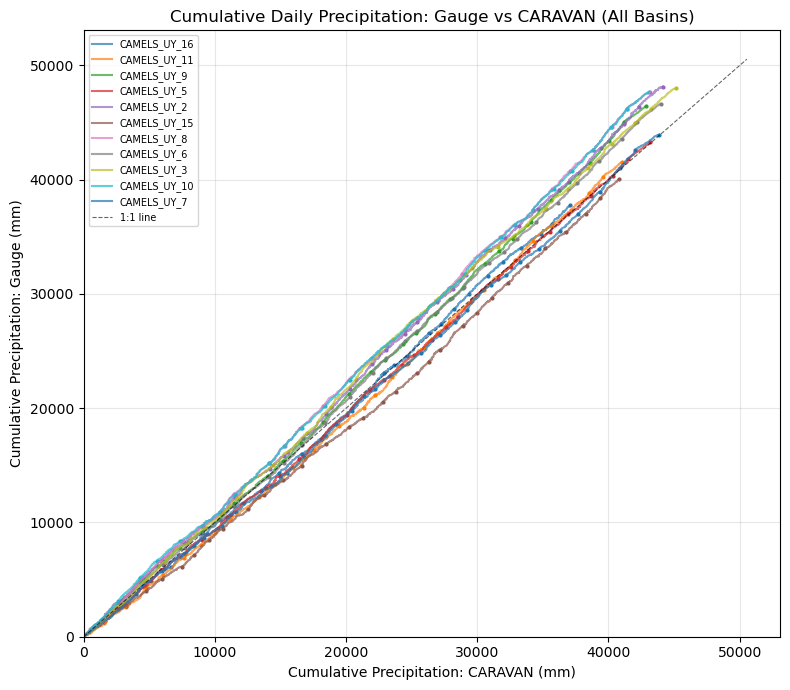

In [42]:
fig, ax = plt.subplots(figsize=(8, 7))

for basin_name, group in gauges_in_basins.groupby("basin_source"):
    print(f"Processing basin: {basin_name}")

    # --- Load and combine gauge data ---
    precip_list = []
    for _, row in group.iterrows():
        if pd.isna(row['estacion_file_name']):
            continue
        gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
        if not gauge_file.exists():
            continue
        gauge_df = pd.read_excel(gauge_file)
        precip_col = [c for c in gauge_df.columns if '[mm]' in c][0]
        gauge_df['Fecha'] = pd.to_datetime(gauge_df['Fecha'])
        gauge_df[precip_col] = pd.to_numeric(gauge_df[precip_col], errors='coerce')
        gauge_df = gauge_df[['Fecha', precip_col]].rename(columns={precip_col: 'precip_gauge'})
        precip_list.append(gauge_df)

    if not precip_list:
        continue

    df_gauge = precip_list[0]
    for i, df in enumerate(precip_list[1:], start=1):
        df_gauge = pd.merge(df_gauge, df, on='Fecha', how='outer', suffixes=('', f'_{i}'))
    gauge_cols = [c for c in df_gauge.columns if 'precip_gauge' in c]
    df_gauge['precip_gauge'] = df_gauge[gauge_cols].mean(axis=1)
    df_gauge = df_gauge[['Fecha', 'precip_gauge']]

    # --- Load model ---
    nc_file = DATA_DIR / f"{group['nc_file_name'].iloc[0]}.nc"
    if not nc_file.exists():
        continue
    ds = xr.open_dataset(nc_file)
    df_model = ds[['prcp_mm_day']].to_dataframe().reset_index()
    df_model = df_model.rename(columns={'date': 'Fecha', 'prcp_mm_day': 'precip_model'})

    # --- Merge ---
    df_all = pd.merge(df_model, df_gauge, on='Fecha', how='left').sort_values('Fecha')

    # --- Compute water year ---
    df_all['water_year'] = df_all['Fecha'].dt.year
    df_all.loc[df_all['Fecha'].dt.month >= 10, 'water_year'] += 1

    # --- Remove incomplete first and last water years ---
    min_wy = df_all['water_year'].min() + 1
    max_wy = df_all['water_year'].max() - 1
    df_all = df_all[(df_all['water_year'] >= min_wy) & (df_all['water_year'] <= max_wy)]

    # --- Compute daily cumulative precipitation ---
    df_all['cum_model'] = df_all['precip_model'].cumsum()
    df_all['cum_gauge'] = df_all['precip_gauge'].cumsum()

    # --- Plot daily cumulative line ---
    line = ax.plot(df_all['cum_model'], df_all['cum_gauge'],alpha=0.7, label=str(group['nc_file_name'].iloc[0]))[0]

    # --- Compute annual totals for markers ---
    annual = df_all.groupby('water_year')[['precip_model', 'precip_gauge']].sum().cumsum().reset_index()

    # --- Add markers at the end of each water year ---
    ax.scatter(annual['precip_model'], annual['precip_gauge'],
               color=line.get_color(), s=4) #, zorder=5)

# --- Add 1:1 reference line ---
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([0, max_val], [0, max_val], '--', color='black', lw=0.8, alpha=0.6,label='1:1 line')

# --- Final plot setup ---
ax.set_xlabel("Cumulative Precipitation: CARAVAN (mm)")
ax.set_ylabel("Cumulative Precipitation: Gauge (mm)")
ax.set_title("Cumulative Daily Precipitation: Gauge vs CARAVAN (All Basins)")
ax.grid(alpha=0.3)
ax.legend(fontsize=7)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.tight_layout()
plt.show()

# --- Save plot ---
out_path = PLOTS_DIR / "cum_daily_precip_with_wy_markers.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.close(fig)


# Precipitation timeseries

In [43]:
# for basin_name, basin_group in gauges_in_basins.groupby("basin_source"):
#     print(f"Saving CSV for basin: {basin_name}")

#     # -------------------- Load & combine gauge data --------------------
#     gauge_dfs = []

#     for _, row in basin_group.iterrows():
#         if pd.isna(row["estacion_file_name"]):
#             continue

#         gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
#         if not gauge_file.exists():
#             continue

#         df = pd.read_excel(gauge_file)
#         precip_col = [c for c in df.columns if "[mm]" in c][0]

#         df["Fecha"] = pd.to_datetime(df["Fecha"])
#         df[precip_col] = pd.to_numeric(df[precip_col], errors="coerce")

#         df = df[["Fecha", precip_col]].rename(columns={precip_col: row["Estacion"]})
#         gauge_dfs.append(df)

#     if not gauge_dfs:
#         continue

#     df_gauge = gauge_dfs[0]
#     for df in gauge_dfs[1:]:
#         df_gauge = pd.merge(df_gauge, df, on="Fecha", how="outer")

#     gauge_cols = df_gauge.columns.drop("Fecha")
#     df_gauge["precip_gauge"] = df_gauge[gauge_cols].mean(axis=1)
#     df_gauge = df_gauge[["Fecha", "precip_gauge"]]

#     # -------------------- Load model data --------------------
#     nc_file = DATA_DIR / f"{basin_group['nc_file_name'].iloc[0]}.nc"
#     if not nc_file.exists():
#         continue

#     ds = xr.open_dataset(nc_file)
#     df_model = (
#         ds[["prcp_mm_day"]]
#         .to_dataframe()
#         .reset_index()
#         .rename(columns={
#             "date": "Fecha",
#             "prcp_mm_day": "precip_model"
#         })
#     )

#     # -------------------- Merge & save CSV --------------------
#     df_basin = (
#         pd.merge(df_model, df_gauge, on="Fecha", how="left")
#         .sort_values("Fecha")
#     )

#     basin_id = basin_group["nc_file_name"].iloc[0]
#     out_csv = OUT_TS_DIR / f"precip_timeseries_{basin_id}.csv"
#     df_basin.to_csv(out_csv, index=False)

# print("✅ Basin precipitation time series saved as CSV files.")

In [44]:
for nc_name, basin_group in gauges_in_basins.groupby("nc_file_name"):
    print(f"Saving CSV for basin: {nc_name}")

    # -------------------- Load & combine gauge data --------------------
    gauge_dfs = []

    for _, row in basin_group.iterrows():
        if pd.isna(row["estacion_file_name"]):
            continue

        gauge_file = UYPRECIP_DIR / f"{row['estacion_file_name']}.xlsx"
        if not gauge_file.exists():
            print(f"  ⚠️ Missing gauge file: {gauge_file}")
            continue

        df = pd.read_excel(gauge_file)
        precip_col = [c for c in df.columns if "[mm]" in c][0]

        df["Fecha"] = pd.to_datetime(df["Fecha"])
        df[precip_col] = pd.to_numeric(df[precip_col], errors="coerce")

        df = df[["Fecha", precip_col]].rename(columns={precip_col: row["Estacion"]})
        gauge_dfs.append(df)

    if not gauge_dfs:
        print(f"  ⚠️ No gauge data for {nc_name}")
        continue

    # Merge all gauges on Fecha
    df_gauge = gauge_dfs[0]
    for df in gauge_dfs[1:]:
        df_gauge = pd.merge(df_gauge, df, on="Fecha", how="outer")

    gauge_cols = df_gauge.columns.drop("Fecha")
    df_gauge["precip_gauge"] = df_gauge[gauge_cols].mean(axis=1)
    df_gauge = df_gauge[["Fecha", "precip_gauge"]]

    # -------------------- Load model data --------------------
    nc_file = DATA_DIR / f"{nc_name}.nc"
    if not nc_file.exists():
        print(f"  ⚠️ Missing NetCDF file: {nc_file}")
        continue

    ds = xr.open_dataset(nc_file)

    df_model = (
        ds[["prcp_mm_day"]]
        .to_dataframe()
        .reset_index()
        .rename(columns={
            "date": "Fecha",
            "prcp_mm_day": "precip_model"
        })
    )

    # -------------------- Merge & save CSV --------------------
    df_basin = (
        pd.merge(df_model, df_gauge, on="Fecha", how="left")
        .sort_values("Fecha")
        .reset_index(drop=True)
    )

    out_csv = OUT_TS_DIR / f"precip_timeseries_{nc_name}.csv"
    df_basin.to_csv(out_csv, index=False)

print("✅ Basin precipitation time series saved using nc_file_name.")

Saving CSV for basin: CAMELS_UY_1
  ⚠️ Missing NetCDF file: filtered_data/time_series/CAMELS_UY_1.nc
Saving CSV for basin: CAMELS_UY_10
Saving CSV for basin: CAMELS_UY_11
Saving CSV for basin: CAMELS_UY_12
  ⚠️ Missing NetCDF file: filtered_data/time_series/CAMELS_UY_12.nc
Saving CSV for basin: CAMELS_UY_13
  ⚠️ Missing NetCDF file: filtered_data/time_series/CAMELS_UY_13.nc
Saving CSV for basin: CAMELS_UY_14
  ⚠️ Missing NetCDF file: filtered_data/time_series/CAMELS_UY_14.nc
Saving CSV for basin: CAMELS_UY_15
Saving CSV for basin: CAMELS_UY_16
Saving CSV for basin: CAMELS_UY_2
Saving CSV for basin: CAMELS_UY_3
Saving CSV for basin: CAMELS_UY_4
  ⚠️ Missing NetCDF file: filtered_data/time_series/CAMELS_UY_4.nc
Saving CSV for basin: CAMELS_UY_5
Saving CSV for basin: CAMELS_UY_6
Saving CSV for basin: CAMELS_UY_7
Saving CSV for basin: CAMELS_UY_8
Saving CSV for basin: CAMELS_UY_9
✅ Basin precipitation time series saved using nc_file_name.
